In [19]:
import pandas as pd
SEED = 123

# Загружаем данные
train = pd.read_csv('./data/processed/train.csv')
test = pd.read_csv('./data/processed/test.csv')

In [29]:
# ==============================================================================
# ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ CATBOOST С OPTUNA
# ==============================================================================

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import optuna

print("\nНачинаем подбор гиперпараметров для CatBoost...")

target = 'resolution'

# Разделяем обработанные данные на обучающую и валидационную выборки.
# Это необходимо для объективной оценки каждой комбинации гиперпараметров.

#features = train.drop(columns=['id', target])
test_features = test.drop(columns=['id', 'name_rus', 'ItemID', 'description'])

features_to_drop = ['id', 'resolution', 'name_rus', 'ItemID', 'description']
features = [col for col in train.columns if col not in features_to_drop]

test_labels = pd.read_csv('multimodal_submission_0.92_with_misha_features.csv')
test[target] = test_labels["prediction"]
train = pd.concat([train, test])
'''

    Во тут поменять надо разделение на трейн и валид учитывая близость последних данных к тесту по времени
    для более точной валидации. 

'''


X_train, X_valid, y_train, y_valid = train_test_split( 
    train[features], train[target], test_size=0.1, stratify=train[target], random_state=SEED
)

# Рассчитываем вес для борьбы с дисбалансом
#counts = y_train.value_counts()
#scale_weight = 14.1

# Определяем целевую функцию для Optuna.
# На каждой итерации Optuna будет вызывать эту функцию с новым набором параметров из заданных диапазонов.
def objective_catboost_fast(trial):
    # Диапазоны скорректированы для поиска лучшего F1-score
    params = {
        'objective': 'Logloss',
        'task_type': 'GPU',
        'eval_metric': 'F1', # <-- ИЗМЕНЕНИЕ 1: Метрика для early stopping
        'verbose': 0, 'random_seed': SEED,
        'allow_writing_files': False, 'task_type': 'GPU', 'devices': '0:1',
        "iterations": trial.suggest_int("iterations", 500, 10000),
        #'scale_pos_weight': scale_weight,
        # 1. Структура деревьев
        'depth': trial.suggest_int('depth', 6, 12), # Ищем более глубокие и сложные деревья
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True), # Расширяем диапазон learning rate
        
        # 2. Регуляризация (борьба с переобучением)
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 2.0, 30.0, log=True), # Более широкий поиск по L2
        #'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.9), # Добавляем отбор признаков на каждом уровне
        
        # 3. Управление скоростью и качеством построения
        'border_count': 254, # Используем больше корзин для числовых признаков
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100), # Новый параметр: минимальное число объектов в листе
        
        # 4. Стохастизация (добавление случайности для устойчивости)
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 2.0), # Расширяем диапазон "агрессивности" бэггинга
        #'subsample': trial.suggest_float('subsample', 0.7, 1.0), # Новый параметр: доля объектов для обучения каждого дерева
    }
    model = CatBoostClassifier(**params, device_config='GPU')
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=100, # Увеличиваем терпение
              verbose=False)
    
    # --- ИЗМЕНЕНИЕ 2: Считаем F1-score ---
    # Для F1 нужны предсказанные классы (0/1), а не вероятности
    preds = model.predict(X_valid)
    return f1_score(y_valid, preds, average='macro') # <-- Используем F1 Macro

# Запускаем исследование
#study_catboost = optuna.create_study(direction='maximize')
#study_catboost.optimize(objective_catboost_fast, n_trials=500)

print("\nПодбор гиперпараметров завершен.")
#print(f"Лучшее значение F1 Macro на валидации: {study_catboost.best_value:.5f}")
#print("Найденные оптимальные параметры:", study_catboost.best_params)


Начинаем подбор гиперпараметров для CatBoost...

Подбор гиперпараметров завершен.



--- Финальное обучение и создание submission ---
Лучшие найденные параметры: {'iterations': 3000, 'depth': 11, 'learning_rate': 0.018160515447969497, 'l2_leaf_reg': 7, 'min_data_in_leaf': 70, 'border_count': 103, 'random_strength': 0.0013520341843385793, 'bagging_temperature': 0.1692463585742141, 'device_config': 'GPU', 'auto_class_weights': 'Balanced', 'early_stopping_rounds': 220}

Начинаем обучение финальной модели на всем тренировочном наборе...
0:	learn: 0.9281491	test: 0.9248924	best: 0.9248924 (0)	total: 25ms	remaining: 1m 14s
100:	learn: 0.9516553	test: 0.9416201	best: 0.9424403 (94)	total: 2.46s	remaining: 1m 10s
200:	learn: 0.9619030	test: 0.9455154	best: 0.9455341 (185)	total: 4.94s	remaining: 1m 8s
300:	learn: 0.9686836	test: 0.9454444	best: 0.9472351 (240)	total: 7.42s	remaining: 1m 6s
400:	learn: 0.9747698	test: 0.9462228	best: 0.9472980 (389)	total: 9.82s	remaining: 1m 3s
500:	learn: 0.9788003	test: 0.9460560	best: 0.9472980 (389)	total: 12.2s	remaining: 1m
bestTest = 0

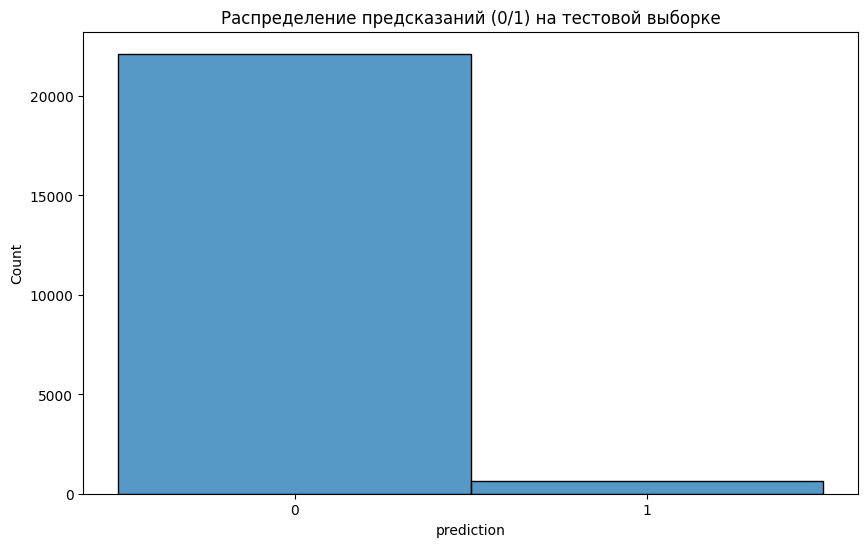

In [30]:
# ==============================================================================
# ФИНАЛЬНОЕ ОБУЧЕНИЕ И СОЗДАНИЕ SUBMISSION
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
print("\n--- Финальное обучение и создание submission ---")

# 'iterations': 1747, 'depth': 10, 'learning_rate': 0.06427389898148692, 'l2_leaf_reg': 5.855800469741403, 
# 'min_data_in_leaf': 69, 'random_strength': 6.651814763888405, 'bagging_temperature': 0.06878560703892056

# 1. Получаем лучшие параметры из исследования Optuna
#best_params = study_catboost.best_params
best_params = {'iterations': 3000, 'depth': 11, 'learning_rate': 0.018160515447969497, 'l2_leaf_reg': 7, 'min_data_in_leaf': 70, 'border_count': 103, 'random_strength': 0.0013520341843385793, 
               'bagging_temperature': 0.1692463585742141, 'device_config': "GPU",
                   'auto_class_weights': 'Balanced', 'early_stopping_rounds': 220}

print("Лучшие найденные параметры:", best_params)

# 2. Дополняем параметры служебными настройками
final_params = best_params.copy()
final_params.update({
    'objective': 'Logloss',
    'eval_metric': 'F1',
    'random_seed': SEED,
    'task_type': 'GPU',
    'devices': '0:1',
    #'scale_pos_weight': scale_weight,
    'verbose': 100 # Выводить лог каждые 200 итераций
})
# iterations уже был подобран Optuna, используем его

# 3. Обучаем модель на ВСЕХ тренировочных данных для максимального качества
# X_train и y_train содержат 75% данных. Для финальной модели используем все 100%.
X_full_train = train[features]
y_full_train = train[target]

final_model = CatBoostClassifier(**final_params)
print("\nНачинаем обучение финальной модели на всем тренировочном наборе...")
# Обучаем ее еще раз на train/valid сплите, чтобы получить историю метрик
final_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=150 # Используем те же параметры, что и в objective
)
print("Обучение завершено.")


# 4. ПОДБОР ОПТИМАЛЬНОГО ПОРОГА НА ВАЛИДАЦИОННОЙ ВЫБОРКЕ
# Это КЛЮЧЕВОЙ шаг для максимизации F1. Мы используем X_valid и y_valid из ячейки с Optuna.
print("\nПодбор оптимального порога на валидационной выборке...")
valid_proba = final_model.predict_proba(X_valid)[:, 1]
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_valid, (valid_proba > t).astype(int)) for t in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Оптимальный порог для F1-score: {best_threshold:.2f}")


# 5. Создание submission-файла
print("\nСоздание файла submission_catboost.csv...")

# Предсказываем ВЕРОЯТНОСТИ для тестовых данных
test_proba = final_model.predict_proba(test_features)[:, 1]

# Применяем оптимальный порог для получения КЛАССОВ (0/1)
test_preds = (test_proba > best_threshold).astype(int)

# Создаем DataFrame для сабмита
probs_df = pd.DataFrame({'id': test['id'], 'prediction': test_proba})
probs_df.to_csv('probabilities_catboost.csv', index=False)
submission_df = pd.DataFrame({'id': test['id'], 'prediction': test_preds})
submission_df.to_csv('submission_catboost.csv', index=False)
print("Файл submission_catboost.csv успешно создан!")

# 6. Финальный анализ полученного submission
print("\nРаспределение предсказаний в submission-файле:")
print(submission_df['prediction'].value_counts(normalize=True))

plt.figure(figsize=(10, 6))
sns.histplot(submission_df['prediction'], discrete=True)
plt.title('Распределение предсказаний (0/1) на тестовой выборке')
plt.xticks([0, 1])
plt.show()



Финальная модель успешно сохранена в файл: final_catboost_model.cbm


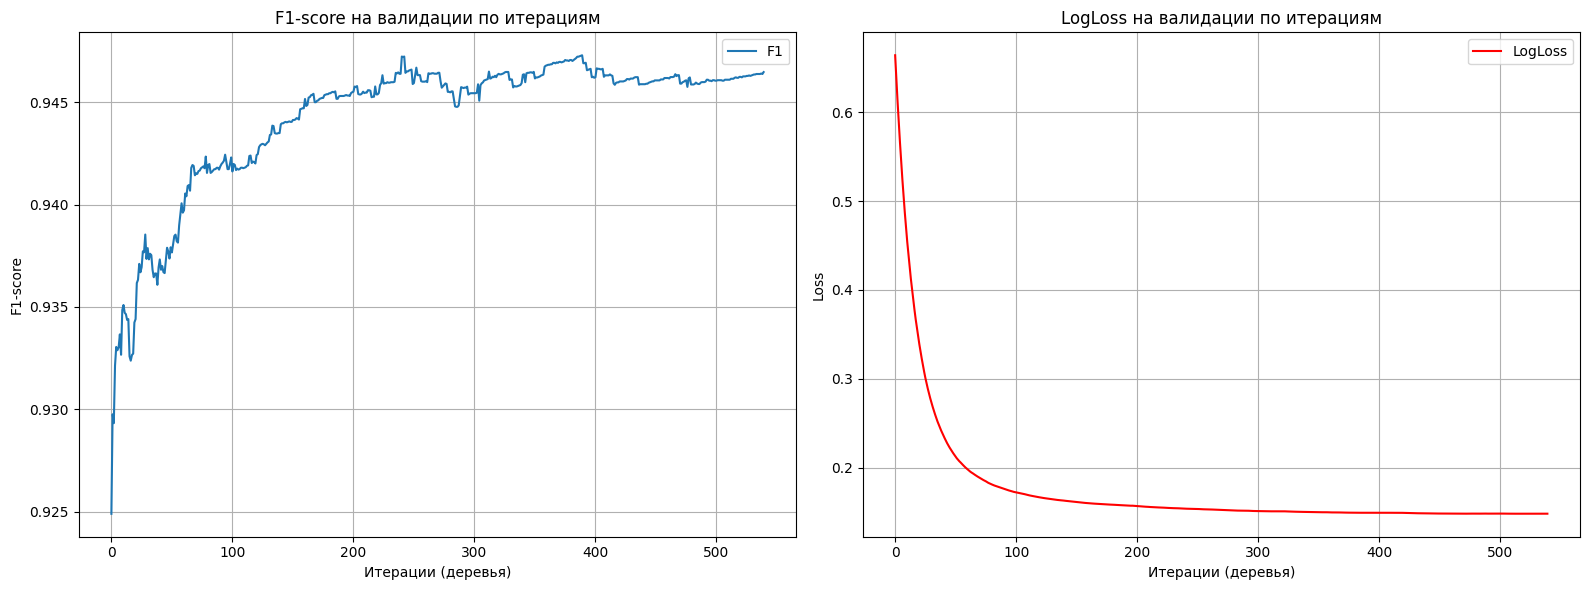


Анализ процесса обучения завершен.


In [31]:
# ==============================================================================
# АНАЛИЗ ПРОЦЕССА ОБУЧЕНИЯ И СОХРАНЕНИЕ МОДЕЛИ
# ==============================================================================

# 1. Сохранение финальной модели в бинарном формате
model_filename = "final_catboost_model.cbm"
final_model.save_model(model_filename)
print(f"\nФинальная модель успешно сохранена в файл: {model_filename}")


# 2. Извлечение истории обучения
# CatBoost сохраняет историю метрик на eval-наборе
evals_result = final_model.get_evals_result()
val_metrics = evals_result['validation']

# 3. Визуализация метрик
epochs = len(val_metrics['F1'])
x_axis = range(0, epochs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График F1
ax1.plot(x_axis, val_metrics['F1'], label='F1')
ax1.set_title('F1-score на валидации по итерациям')
ax1.set_xlabel('Итерации (деревья)')
ax1.set_ylabel('F1-score')
ax1.legend()
ax1.grid(True)

# График LogLoss
ax2.plot(x_axis, val_metrics['Logloss'], label='LogLoss', color='red')
ax2.set_title('LogLoss на валидации по итерациям')
ax2.set_xlabel('Итерации (деревья)')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print("\nАнализ процесса обучения завершен.")



--- Анализ важности признаков финальной модели ---
Топ-10 самых важных признаков:
CommercialTypeName4_te            12.506709
SellerID_te                        9.239283
brand_name_te                      8.144533
ItemVarietyCount_scaled            5.197520
brand_popularity_in_cat_scaled     4.500682
price_vs_global_median_scaled      3.860547
brand_frequency_scaled             3.811795
seller_category_entropy_scaled     3.388555
digits_in_name_ratio_scaled        3.320869
item_time_alive_scaled             3.291931
dtype: float64


/tmp/ipykernel_676035/1518133778.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="mako")


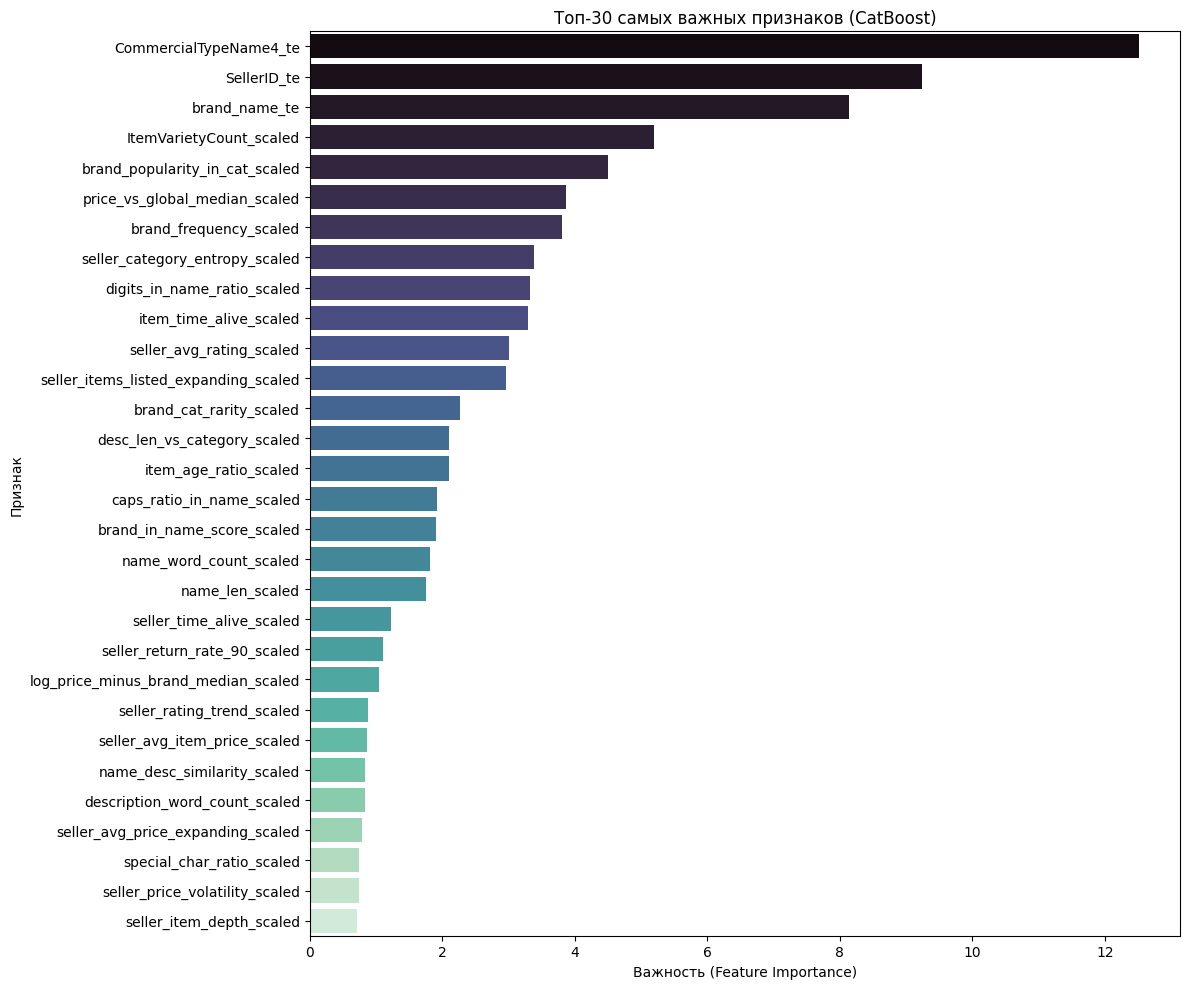

In [32]:
# ==============================================================================
# АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
# ==============================================================================

print("\n--- Анализ важности признаков финальной модели ---")

# Извлекаем важность признаков из обученной модели
feature_importance = pd.Series(
    final_model.get_feature_importance(), 
    index=final_model.feature_names_
)

# Сортируем и выбираем топ-30 для наглядности
top_features = feature_importance.sort_values(ascending=False).head(30)

print("Топ-10 самых важных признаков:")
print(top_features.head(10))

# Визуализация важности признаков
plt.figure(figsize=(12, 10))
sns.barplot(x=top_features.values, y=top_features.index, palette="mako")
plt.title('Топ-30 самых важных признаков (CatBoost)')
plt.xlabel('Важность (Feature Importance)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


In [38]:
cat_probs = pd.read_csv('probabilities_catboost.csv')
best_probs = pd.read_csv('probabilities_of_0.92_best_0.7674.csv')
ftt_probs = pd.read_csv('probabilities_0.6_plus_fit_ftt_transformer_116_features.csv')
probs = 0.75*cat_probs["prediction"]+0.14*best_probs["probability"]+0.11*ftt_probs['probability']
preds = (probs > 0.73).astype(int)
#print(preds)
#print(cat_probs['prediction'], best_probs['probability'], ftt_probs['probability'])
ensemble = pd.DataFrame({'id': test['id'], 'prediction': preds})
ensemble.to_csv('ensemble_v2.6_0.73.csv', index=False)

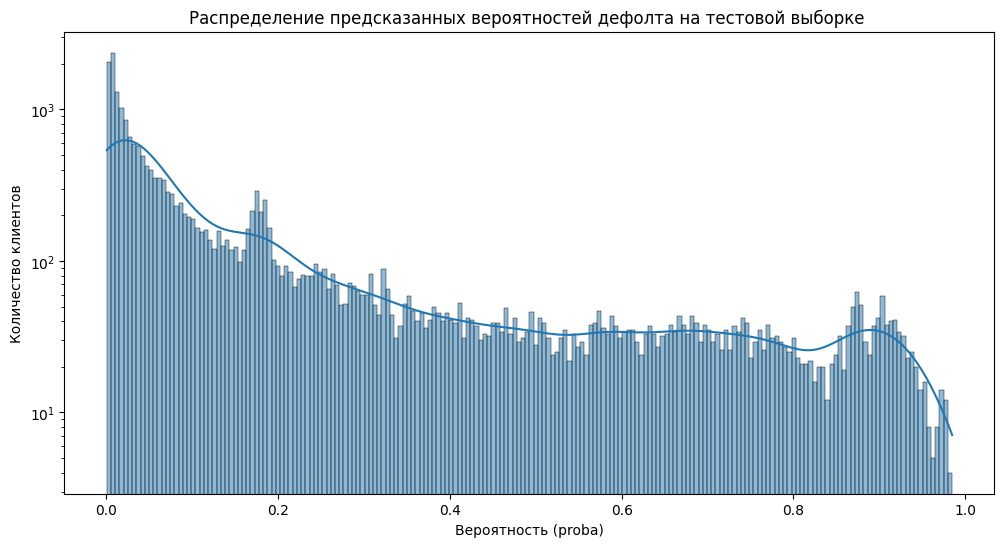

In [27]:
plt.figure(figsize=(12, 6))
sns.histplot(probs, bins=200, kde=True)
plt.title('Распределение предсказанных вероятностей дефолта на тестовой выборке ')
plt.xlabel('Вероятность (proba)')
plt.yscale('log')
plt.ylabel('Количество клиентов')
plt.show()

In [145]:
from collections import defaultdict

distribution = defaultdict(int)
step = 0.005
# Группируем вероятности по интервалам
for prob in probs:
    # Округляем до ближайшего шага (умножаем, округляем, делим)
    bucket = round(prob / step) * step
    # Обеспечиваем, что значения остаются в пределах [0, 1]
    bucket = max(0, min(1, bucket))
    distribution[bucket] += 1

# Создаем DataFrame для удобства
df = pd.DataFrame({
    'probability_interval': sorted(distribution.keys()),
    'count': [distribution[bucket] for bucket in sorted(distribution.keys())]
})

# Добавляем процентное соотношение
total = len(probs)
df['percentage'] = (df['count'] / total) * 100

print(df)
df.to_csv('probs_analys.csv', index=False)

     probability_interval  count  percentage
0                   0.000   7559   33.211775
1                   0.005   4900   21.528998
2                   0.010   2314   10.166960
3                   0.015   1084    4.762742
4                   0.020    642    2.820738
..                    ...    ...         ...
193                 0.965     14    0.061511
194                 0.970      3    0.013181
195                 0.975      5    0.021968
196                 0.980      1    0.004394
197                 0.985      1    0.004394

[198 rows x 3 columns]


44
674
1219
